In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier

In [2]:
df = pd.read_csv('data/processed_dataset.csv')
df.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,...,feature_76,feature_77,feature_78,feature_79,feature_80,feature_81,feature_82,feature_83,feature_84,feature_85,feature_86,feature_87,feature_88,feature_89,feature_90,feature_91,feature_92,feature_93,feature_94,feature_95,feature_96,feature_97,feature_98,feature_99,feature_100,feature_101,feature_102,feature_103,feature_104,feature_105,feature_106,feature_107,feature_108,feature_109,feature_110,feature_111,feature_112,feature_113,feature_114,x
0,365.557527,1335.757057,182800.750816,621.329382,1335.056746,184897.736676,1929.143451,1339.442472,182189.972772,19594.846200,1341.414651,180729.984363,152094.231884,1339.876966,182719.188650,365.557527,1335.757057,182800.750816,621.329382,1335.056746,184897.736676,1929.143451,1339.442472,182189.972772,19594.846200,1341.414651,180729.984363,152094.231884,1339.876966,182719.188650,365.557527,1335.757057,427.552045,1455.808672,182840.138225,102.396019,0.003888,621.329382,1335.056746,429.997368,...,3.986651e+07,152091.188426,2231.358063,3.352094e+12,51.248909,1334.927997,428.865201,1334.927997,183925.360861,0.000000e+00,0.000000e+00,87.510203,1335.015325,430.234600,1335.015325,185101.810734,0.000000e+00,0.000000e+00,274.135336,1340.508931,425.548652,1340.508931,181091.655230,0.000000e+00,0.000000e+00,2795.048781,1342.714316,423.439100,1342.714316,179300.671259,0.000000,0.000000,21701.798045,1341.313287,425.609255,1341.313287,181143.237622,0.000000,0.000000,0
1,383.630242,1338.051100,185263.016689,643.508749,1343.111554,179394.175863,1953.630364,1344.719713,176069.204781,19633.267292,1340.887857,180503.605425,160921.789333,1339.947597,182456.860127,383.630242,1338.051100,185263.016689,643.508749,1343.111554,179394.175863,1953.630364,1344.719713,176069.204781,19633.267292,1340.887857,180503.605425,160921.789333,1339.947597,182456.860127,383.630242,1338.051100,430.421905,1358.435273,185263.363529,-25.473743,-0.003126,643.508749,1343.111554,423.549496,...,4.358650e+06,160918.491281,1690.543613,2.539647e+12,57.300664,1338.362958,431.697213,1338.362958,186362.483710,0.000000e+00,0.000000e+00,94.290117,1343.705560,423.792853,1343.705560,179600.382640,0.000000e+00,0.000000e+00,281.011772,1345.606911,418.740151,1345.606911,175343.314274,0.000000e+00,0.000000e+00,2803.475145,1342.226174,423.147155,1342.226174,179053.514789,0.000000,0.000000,22963.287017,1341.376388,425.313054,1341.376388,180891.194210,0.000000,0.000000,0
2,161.171251,1289.108527,148890.944034,272.817589,1291.789855,145610.524769,850.608208,1295.862676,141072.680486,8698.360527,1296.799024,140220.635168,85165.727486,1296.362040,140181.765281,161.171251,1289.108527,148890.944034,272.817589,1291.789855,145610.524769,850.608208,1295.862676,141072.680486,8698.360527,1296.799024,140220.635168,85165.727486,1296.362040,140181.765281,161.171251,1289.108527,385.863893,1290.504085,148890.944034,0.000090,0.000013,272.817589,1291.789855,381.589472,...,6.887305e-05,85162.712216,29.121186,4.374531e+10,52.090912,1229.975610,237.618574,1231.438184,56462.586929,7.939867e-14,2.215964e-10,91.431761,1229.304605,237.415515,1230.767976,56366.126693,5.975744e-13,1.523780e-09,295.969763,1228.406426,236.713621,1229.870866,56033.338340,4.199467e-13,1.176524e-09,3069.717940,1229.114443,233.194252,1230.578041,54379.559141,0.000001,0.000003,25333.628562,1228.267621,235.430296,1229.732699,55427.424500,0.147639,0.000485,1
3,165.591681,1287.269215,145583.630014,274.950726,1286.338594,148125.083665,846.251248,1289.109749,147033.406716,8704.393559,1294.756457,142324.020569,59633.130960,1296.884943,141649.825151,165.591681,1287.269215,145583.6

# Globals

In [3]:
def get_model_metrics(model_name, y_true, y_pred):
    metrics = {}
    metrics['Model'] = model_name
    metrics['Accuracy'] = accuracy_score(y_true, y_pred)
    metrics['ROC-AUC Score'] = roc_auc_score(y_true, y_pred)
    metrics['F1-Score'] = f1_score(y_true, y_pred)
    metrics['Precision'] = precision_score(y_true, y_pred)
    metrics['Recall'] = recall_score(y_true, y_pred)
    
    return metrics

metrics_table = list()

# Model building

### Train-test split

In [4]:
# Split the dataset into training and testing sets
X = df.drop(['x'], axis=1) # features
y = df['x'] # target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Feature selection

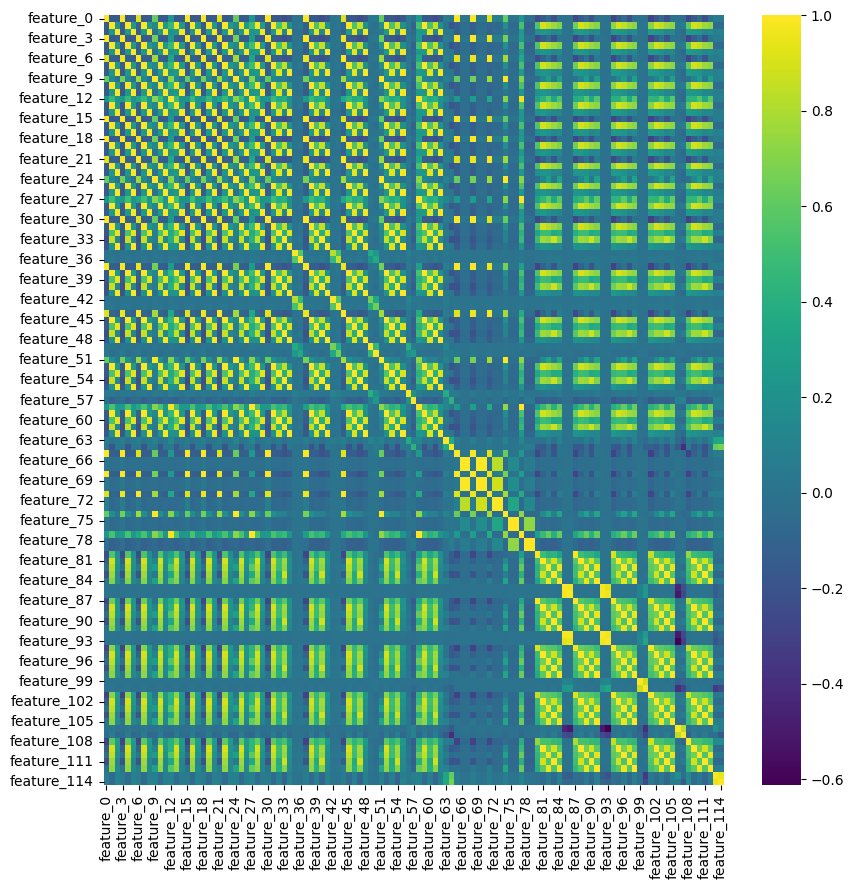

In [5]:
plt.figure(figsize=(10, 10))
sns.heatmap(X.corr(), cmap='viridis')
plt.show()

In [6]:
num_features = 50

selector = SelectKBest(f_classif, k=num_features)
X_train = selector.fit_transform(X_train, y_train)
X_test = selector.transform(X_test)

### Decision Tree Classifier

In [7]:
# Define the parameter grid to search over
param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10],
    'min_samples_leaf': [1, 2, 3],
}

dt = DecisionTreeClassifier(random_state=42)

grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

KeyboardInterrupt: 

In [7]:
# Create an instance of the model with the best parameters
best_dt = DecisionTreeClassifier(
    criterion='gini',
    max_depth=10,
    min_samples_leaf=1,
    min_samples_split=8,
    random_state=42,
)

best_dt.fit(X_train, y_train)

# Calculate predictions on Model
y_pred_dt = best_dt.predict(X_test)

# Get the Performance metrics by method created above
metric_dt = get_model_metrics(model_name="DecisionTreeClassifier", y_true=y_test, y_pred = y_pred_dt)
metrics_table.append(metric_dt)

# Display metric dictionary in df
pd.DataFrame.from_dict(metric_dt, orient='index', columns=['Value'])

,Value
Model,DecisionTreeClassifier
Accuracy,0.934923
ROC-AUC Score,0.934552
F1-Score,0.928825
Precision,0.927362
Recall,0.930292


### Random Forest Classifier

In [9]:
# Define the parameter grid to search over
param_grid = {
    'n_estimators': [50, 100, 150],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10],
    'min_samples_leaf': [1, 2, 3],
}

rf = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

KeyboardInterrupt: 

In [8]:
# Train and evaluate the model with the best hyperparameters
best_rf = RandomForestClassifier(
    criterion='entropy',
    max_depth=10,
    min_samples_leaf=3,
    min_samples_split=10,
    n_estimators=50,
)

best_rf.fit(X_train, y_train)

y_pred_rf = best_rf.predict(X_test)

metric_rf = get_model_metrics(model_name="RandomForestClassifier", y_true=y_test, y_pred = y_pred_rf)
metrics_table.append(metric_rf)

#display metric dictionary in df
pd.DataFrame.from_dict(metric_rf, orient='index', columns=['Value'])

,Value
Model,RandomForestClassifier
Accuracy,0.941683
ROC-AUC Score,0.940034
F1-Score,0.935144
Precision,0.949613
Recall,0.92111


### Gradient Boosting Classifier (GBT)

In [11]:
# Define the parameter grid to search over
# Тут сильно меньше параметров потому что изначально модель не посчиталась даже за 11 часов
param_grid = {
    'boosting_type': ['gbdt'],
    'n_estimators': [50, 100, 150, 200, 300],
    'learning_rate': [0.1, 0.05, 0.15],
    'max_depth': [10, 20, 31, 40],
    'min_child_samples': [2, 10, 20, 30, 40, 50],
}

gb = LGBMClassifier(random_state=42, n_jobs=-1)

grid_search = GridSearchCV(estimator=gb, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Best parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.15, 'max_depth': 31, 'min_child_samples': 30, 'n_estimators': 300}
Best score: 0.9613880908117851


In [9]:
best_gb = LGBMClassifier(
    boosting_type='gbdt',
    learning_rate=0.15,
    max_depth=31,
    min_child_samples=30,
    n_estimators=300,
    random_state=42,
)

best_gb.fit(X_train, y_train)

y_pred_gb = best_gb.predict(X_test)

metric_gb = get_model_metrics(model_name="LGBMClassifier", y_true=y_test, y_pred=y_pred_gb)
metrics_table.append(metric_gb)

# Display metric dictionary in df
pd.DataFrame.from_dict(metric_gb, orient='index', columns=['Value'])

,Value
Model,LGBMClassifier
Accuracy,0.963946
ROC-AUC Score,0.963939
F1-Score,0.960638
Precision,0.957434
Recall,0.963863


### Compare classifiers

In [10]:
metric_df = pd.DataFrame(metrics_table)
metric_df.style.highlight_max(axis=0, subset=metric_df.columns[1:])

,Model,Accuracy,ROC-AUC Score,F1-Score,Precision,Recall
0,DecisionTreeClassifier,0.934923,0.934552,0.928825,0.927362,0.930292
1,RandomForestClassifier,0.941683,0.940034,0.935144,0.949613,0.921110
2,LGBMClassifier,0.963946,0.963939,0.960638,0.957434,0.963863


### Visualize GBT classifier

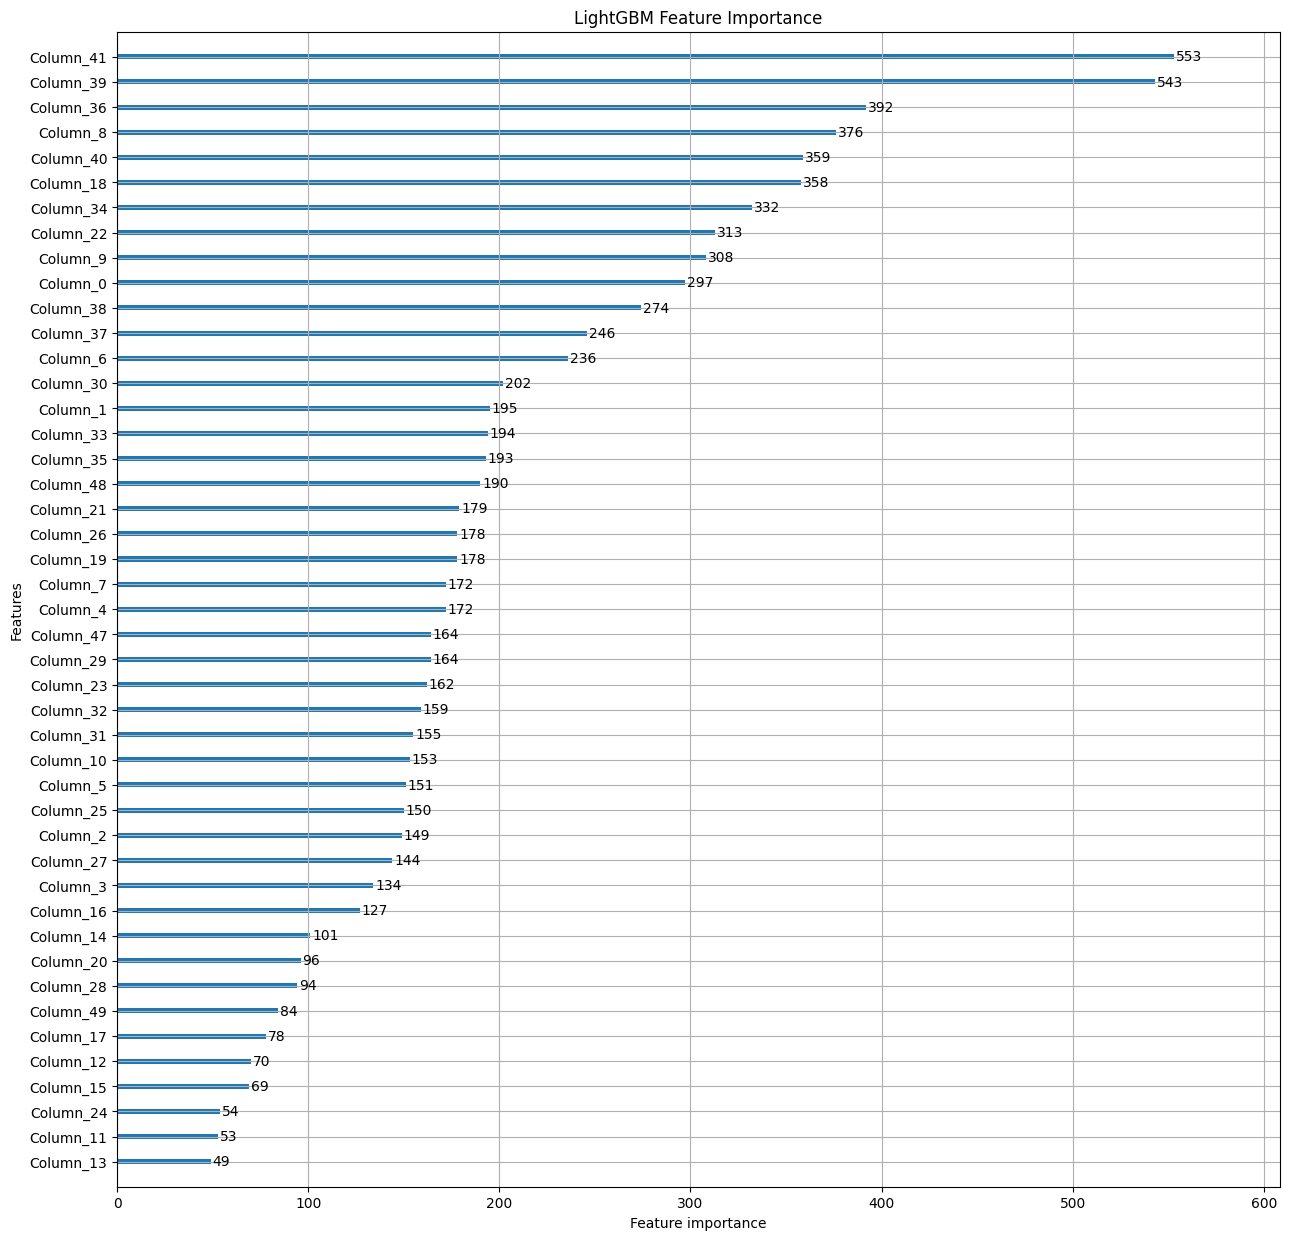

In [11]:
lgb.plot_importance(best_gb, figsize=(15,15), title="LightGBM Feature Importance")
plt.show()

<AxesSubplot:>

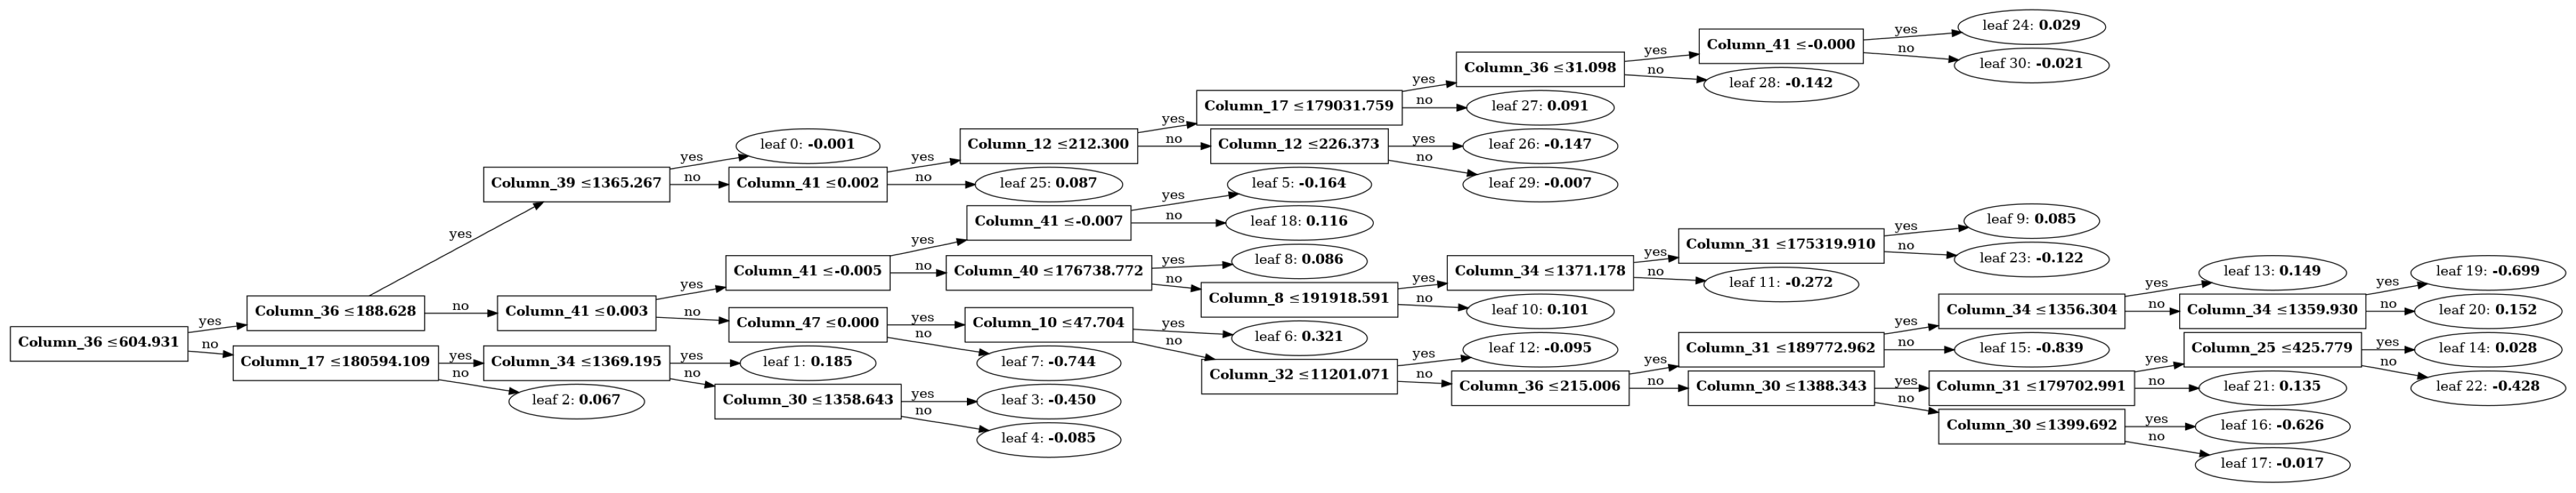

In [12]:
lgb.plot_tree(best_gb, tree_index=69, figsize=(50, 50))

# Parallel execution
Compare model training time depending on a number of CPUs

In [14]:
best_gb = LGBMClassifier(
    boosting_type='gbdt',
    learning_rate=0.15,
    max_depth=31,
    min_child_samples=30,
    n_estimators=300,
    random_state=42,
    n_jobs=1 # 2, 4, 8, 16, 32, 64, 112 (max)
)

best_gb.fit(X_train, y_train)

LGBMClassifier(learning_rate=0.15, max_depth=31, min_child_samples=30,
               n_estimators=300, n_jobs=1, random_state=42)

In [13]:
'''
1 - 4.64s
2 - 2.82s
4 - 1.81s
8 - 1.21s
16 - 1.07s
32 - 1.05s
64 - 1.46s
112 - 2.26s

'''

'\n1 - 4.64s\n2 - 2.82s\n4 - 1.81s\n8 - 1.21s\n16 - 1.07s\n32 - 1.05s\n64 - 1.46s\n112 - 2.26s\n\n'

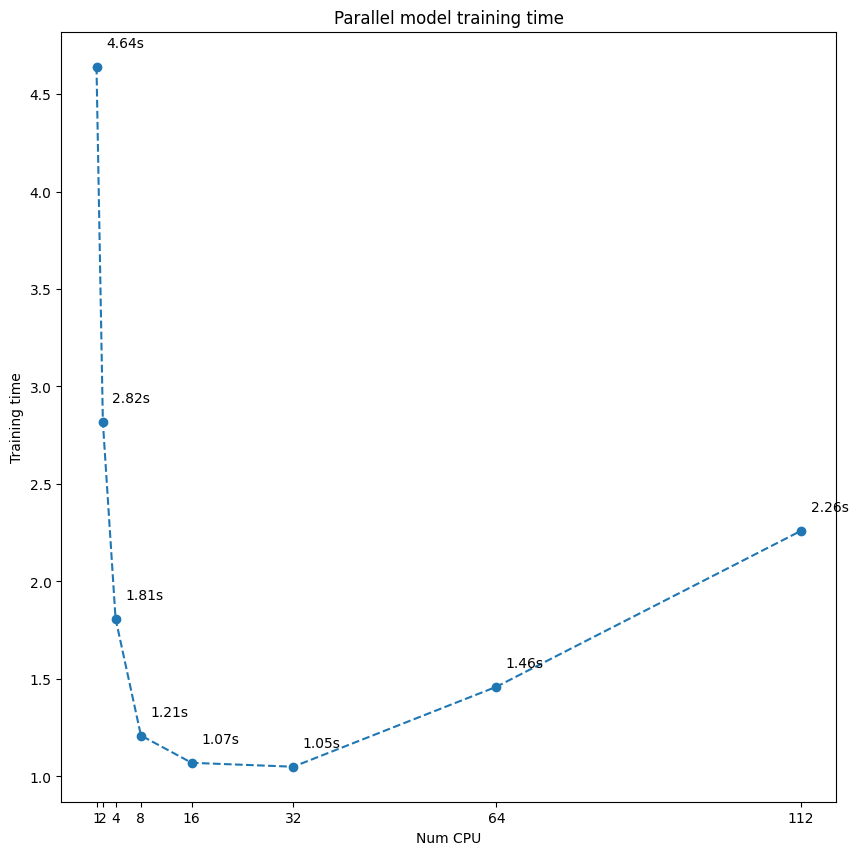

In [47]:
x = [1,2,4,8,16,32,64,112]
y = [4.64, 2.82, 1.81, 1.21, 1.07, 1.05, 1.46, 2.26]

plt.figure(figsize=(10, 10))
plt.title('Parallel model training time')
plt.xlabel('Num CPU')
plt.ylabel('Training time')
plt.plot(x, y, linestyle='--', marker='o')

txt = [str(i) + 's' for i in y]
for i in range(len(x)):
    plt.annotate(txt[i], (x[i] + 1.5, y[i] + 0.1))
    
_ = plt.xticks(x)